#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 13
**CH11 Used cars**

using the used-cars dataset

version 0.9.0 2025-08-14

In [1]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pyfixest as pf
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/used-cars/clean/"
data_out = dirname + "da_case_studies/ch13-used-cars-reg/"
output = dirname + "da_case_studies/ch13-used-cars-reg/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
# Import the prewritten helper functions
import py_helper_functions as da

# Set custom color scheme for plots
sns.set_theme(rc=da.da_theme, palette=da.color)

In [4]:
# DATA IMPORT
data = pd.read_csv(data_in + "used-cars_2cities_prep.csv")
#data = pd.read_csv("https://osf.io/7gvz9/download")



In [5]:
# SAMPLE DESIGN

# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["condition"] = data["condition"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")


In [6]:
# drop hybrid models then drop column
data = data.loc[data.Hybrid == 0].drop(["Hybrid"], axis=1)


In [7]:
# check frequency by fuel type
freq = data.groupby("fuel").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
fuel,,,
Missing,1,0.190,0.190
diesel,1,0.190,0.380
gas,516,98.099,98.479
hybrid,1,0.190,98.669
other,7,1.331,100.000


In [8]:
# keep gas-fuelled vehicles
data = data.loc[data.fuel == "gas"]


In [9]:
# check frequency by vehicle condition
freq = data.groupby("condition").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
condition,,,
Missing,207,40.116,40.116
excellent,133,25.775,65.891
fair,14,2.713,68.604
good,106,20.543,89.147
like new,53,10.271,99.418
new,3,0.581,99.999


In [10]:
# drop vehicles in fair and new condition, trucks
data = data.loc[~data.condition.isin(["new", "fair"])]

# drop unrealistic values for price and odometer reading
data = data.loc[(data.price >= 500) & (data.price <= 25000) & (data.odometer <= 100)]

# drop if price is smaller than 1000 and condition is like new or age is less than 8
data = data.loc[
    ~((data.price < 1000) & ((data.condition == "like new") | (data.age < 8)))
]


In [11]:
# check frequency by transmission
freq = data.groupby("transmission").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
transmission,,,
automatic,478,98.557,98.557
manual,7,1.443,100.000


In [12]:
data = data.loc[~(data.transmission == "manual")]


In [13]:
# check frequency by transmission
freq = data.groupby("type").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
type,,,
Missing,223,46.653,46.653
SUV,1,0.209,46.862
convertible,6,1.255,48.117
coupe,19,3.975,52.092
pickup,1,0.209,52.301
sedan,227,47.490,99.791
wagon,1,0.209,100.000


In [14]:
# drop if truck
data = data.loc[~(data.type == "truck")]
# drop pricestr
data = data.drop(["pricestr"], axis=1)


In [15]:
# DATA GENERATION & DESCRIPTIVES
# CONDITION
data["cond_excellent"] = np.where(data["condition"] == "excellent", 1, 0)
data["cond_good"] = np.where(data["condition"] == "good", 1, 0)
data["cond_likenew"] = np.where(data["condition"] == "like new", 1, 0)
# cylinders
data["cylind6"] = np.where(data["cylinders"] == "6 cylinders", 1, 0)
data.cylinders.value_counts()
data.cylind6.value_counts()
# age: quadratic, cubic
data["agesq"] = data["age"] ** 2
data["agecu"] = data["age"] ** 3
# odometer quadratic
data["odometersq"] = data["odometer"] ** 2


In [16]:
# Frequency tables

# area
data.groupby("area").agg(frequency=("price", "size"), mean=("price", np.mean))


,frequency,mean
area,,
chicago,281,6060.975089
los angeles,197,5518.253807


In [17]:
# focus only on Chicago
data = data.loc[data.area == "chicago"]


In [18]:
# condition
data.groupby("condition").agg(frequency=("price", "size"), mean=("price", np.mean))


,frequency,mean
condition,,
Missing,124,6611.161290
excellent,75,6724.186667
good,67,3988.179104
like new,15,7455.200000


In [19]:
# drive
data.groupby("drive").agg(frequency=("price", "size"), mean=("price", np.mean))


,frequency,mean
drive,,
4wd,4,10168.750000
Missing,106,4575.094340
fwd,169,6893.485207
rwd,2,6250.000000


In [20]:
# dealer
data.groupby("dealer").agg(frequency=("price", "size"), mean=("price", np.mean))


,frequency,mean
dealer,,
0,193,4402.181347
1,88,9699.011364


In [21]:
# data summary
data.loc[
    :,
    [
        "age",
        "odometer",
        "LE",
        "XLE",
        "SE",
        "cond_likenew",
        "cond_excellent",
        "cond_good",
        "cylind6",
    ],
].describe()


,age,odometer,LE,XLE,SE,cond_likenew,cond_excellent,cond_good,cylind6
count,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000
mean,12.298932,12.521702,0.192171,0.071174,0.064057,0.053381,0.266904,0.238434,0.145907
std,5.892153,5.172572,0.394710,0.257575,0.245291,0.225193,0.443131,0.426886,0.353643
min,1.000000,0.231900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,8.140000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.000000,13.655900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17.000000,16.430000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,27.000000,25.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
# Histograms not in the textbook


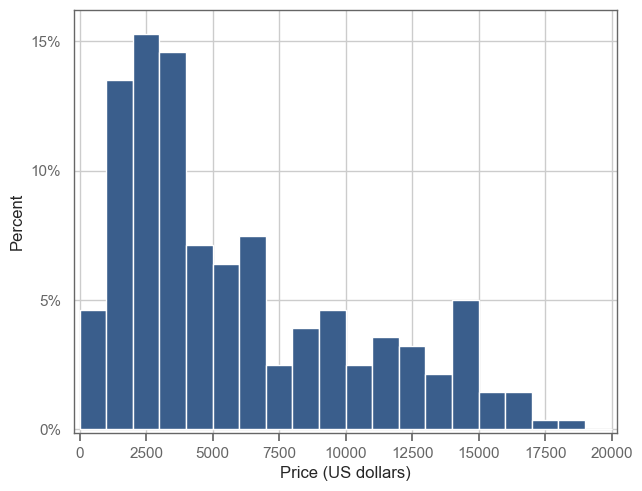

In [23]:
fig = sns.histplot(
    data,
    x="price",
    stat="percent",
    binwidth=1000,
    binrange=(1, 20000),
    alpha=1,
)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))
plt.yticks(da.seq(0, 15, 5))
plt.xlim(0, 20000)
plt.xlabel("Price (US dollars)")
da.add_margin(fig, x=0.01, y=0.01)
plt.show()

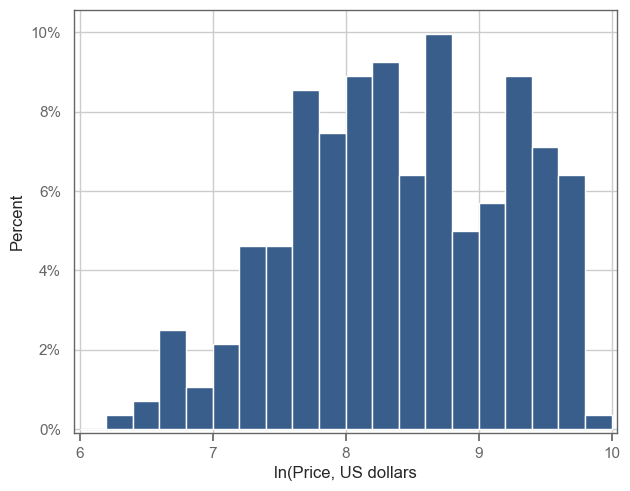

In [24]:
fig = sns.histplot(
    data,
    x="lnprice",
    stat="percent",
    binwidth=0.2,
    binrange=(6, 10),
    alpha=1,
)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))
plt.xticks(da.seq(6, 10, 1))
plt.xlim(6, 10)
plt.xlabel("ln(Price, US dollars")
da.add_margin(fig, x=0.01, y=0.01)
plt.show()

### Regression analysis

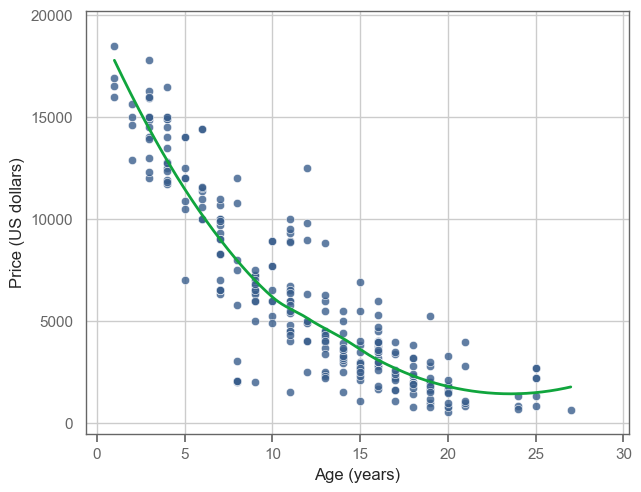

In [25]:
fig = sns.scatterplot(data=data, x="age", y="price", alpha=0.8)
da.plot_loess(data, "age", "price", span=0.8)
plt.xlabel("Age (years)")
plt.ylabel("Price (US dollars)")
plt.xticks(da.seq(0, 30, 5))
plt.yticks(da.seq(0, 20000, 5000))
da.add_margin(fig, x=0.01, y=0.01)
plt.show()

In [26]:
data.describe()


,odometer,dealer,price,lnprice,year,age,lnodometer,LE,XLE,SE,cond_excellent,cond_good,cond_likenew,cylind6,agesq,agecu,odometersq
count,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000
mean,12.521702,0.313167,6060.975089,8.410963,2005.701068,12.298932,2.399433,0.192171,0.071174,0.064057,0.266904,0.238434,0.053381,0.145907,185.857651,3141.096085,183.453306
std,5.172572,0.464609,4490.818067,0.812821,5.892153,5.892153,0.590359,0.394710,0.257575,0.245291,0.443131,0.426886,0.225193,0.353643,150.578697,3504.795719,127.300387
min,0.231900,0.000000,550.000000,6.309918,1991.000000,1.000000,-1.461449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.053778
25%,8.140000,0.000000,2500.000000,7.824046,2001.000000,7.000000,2.096790,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000,343.000000,66.259600
50%,13.655900,0.000000,4400.000000,8.389359,2005.000000,13.000000,2.614172,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,169.000000,2197.000000,186.483605
75%,16.430000,1.000000,8995.000000,9.104425,2011.000000,17.000000,2.799109,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,289.000000,4913.000000,269.944900
max,25.300000,1.000000,18495.000000,9.825255,2017.000000,27.000000,3.230804,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,729.000000,19683.000000,640.090000


In [27]:
###################################
# Linear regressions

# Model 1: Linear regression on age
model1 = "price ~ age + agesq"

# Models 2-5: Multiple linear regressions
# note: condition - missing will be baseline for regs
model2 = "price ~ age + agesq + odometer"
model3 = "price ~ age + agesq + odometer + odometersq + LE + cond_excellent + cond_good + dealer"
model4 = "price ~ age + agesq + odometer + odometersq + LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer"
model5 = "price ~ age + agesq + odometer + odometersq + LE * age + XLE * age + SE * age + cond_likenew * age + cond_excellent * age + cond_good * age + cylind6 * age + odometer * age + dealer * age"

model_equations = [model1, model2, model3, model4, model5]

Estimate regressions

In [28]:
regs = []
for equation in model_equations:
    regs.append(pf.feols(equation, data, vcov="HC1"))

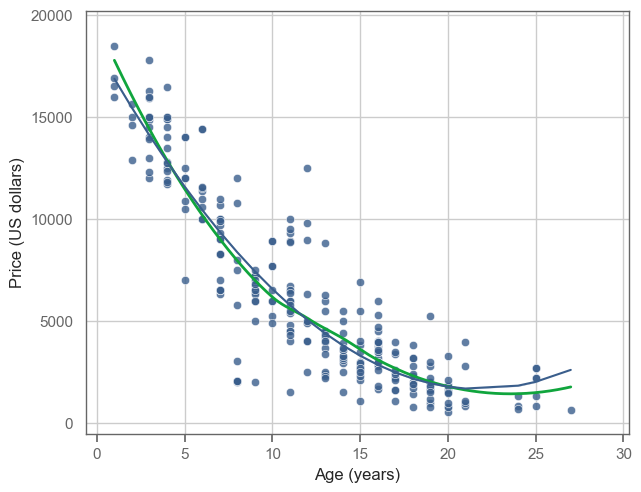

In [29]:
fig = sns.scatterplot(data=data, x="age", y="price", alpha=0.8)
da.plot_loess(data, "age", "price", span=0.8)
data["reg0preds"] = regs[0].predict()
sns.lineplot(data, x="age", y="reg0preds")

plt.xlabel("Age (years)")
plt.ylabel("Price (US dollars)")
plt.xticks(da.seq(0, 30, 5))
plt.yticks(da.seq(0, 20000, 5000))
da.add_margin(fig, x=0.01, y=0.01)
plt.show()

### Table 13.2 Regression models for predicting used car price

In [30]:
pf.etable(regs[:4])

GT(_tbl_data=   level_0             level_1                            0  \
0     coef                 age   -1530.088*** <br> (59.643)   
1     coef               agesq       35.048*** <br> (2.314)   
2     coef            odometer                                
3     coef          odometersq                                
4     coef                  LE                                
5     coef      cond_excellent                                
6     coef           cond_good                                
7     coef              dealer                                
8     coef                 XLE                                
9     coef                  SE                                
10    coef        cond_likenew                                
11    coef             cylind6                                
12    coef           Intercept  1.837E+04*** <br> (353.534)   
13   stats        Observations                          281   
14   stats           S.E. type                       hetero   
15   stats       R<sup>2</sup>                        0.847   
16   stats  Adj. R<sup>2</sup>                        0.846   

                              1                            2  \
0    -1149.223*** <br> (70.123)    -873.473*** <br> (82.351)   
1        27.653*** <br> (2.558)       18.214*** <br> (2.602)   
2     -303.840*** <br> (31.105)    -779.898*** <br> (88.245)   
3                                     18.808*** <br> (2.735)   
4                                      28.113 <br> (202.578)   
5                                     176.487 <br> (194.196)   
6                                     293.361 <br> (223.992)   
7                                    572.976* <br> (224.363)   
8                                                              
9                                                              
10                                                             
11                                                             
12  1.886E+04*** <br> (313.505)  1.943E+04*** <br> (418.947)   
13                          281                          281   
14                       hetero                       hetero   
15                        0.898                        0.913   
16                        0.897                        0.910   

                              3  
0     -836.643*** <br> (78.535)  
1        17.630*** <br> (2.472)  
2     -788.702*** <br> (84.644)  
3        19.200*** <br> (2.662)  
4        -20.482 <br> (207.509)  
5        190.403 <br> (208.324)  
6        321.558 <br> (233.367)  
7     822.649*** <br> (237.332)  
8        301.685 <br> (365.083)  
9      1338.787* <br> (527.717)  
10       558.674 <br> (393.994)  
11      -370.275 <br> (257.255)  
12  1.896E+04*** <br> (451.933)  
13                          281  
14                       hetero  
15                        0.919  
16                        0.916  , _body=<great_tables._gt_data.Body object at 0x17db52db0>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x17da7b1a0>, _spanners=Spanners([SpannerInfo(spanner_id='price', spanner_level=1, spanner_label='price', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2', '3'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stu

Model 5 - not displayed in book

In [31]:
regs[4].summary()

###

Estimation:  OLS
Dep. var.: price, Fixed effects: 0
Inference:  HC1
Observations:  281

| Coefficient        |   Estimate |   Std. Error |   t value |   Pr(>|t|) |      2.5% |     97.5% |
|:-------------------|-----------:|-------------:|----------:|-----------:|----------:|----------:|
| Intercept          |  18476.060 |      767.723 |    24.066 |      0.000 | 16964.285 | 19987.835 |
| age                |   -800.552 |       97.208 |    -8.235 |      0.000 |  -991.971 |  -609.133 |
| agesq              |     11.210 |        3.463 |     3.238 |      0.001 |     4.392 |    18.029 |
| odometer           |   -783.812 |       77.321 |   -10.137 |      0.000 |  -936.070 |  -631.554 |
| odometersq         |     13.099 |        3.591 |     3.647 |      0.000 |     6.027 |    20.171 |
| LE                 |   1002.585 |      818.037 |     1.226 |      0.221 |  -608.265 |  2613.435 |
| XLE                |    863.794 |      936.233 |     0.923 |      0.357 |  -979.804 |  2707.392 |
| SE   

## Cross validation

Use custom function `ols_crossvalidator` for cross validation

In [32]:
# help(ols_crossvalidator)

Set n_fold = 4 for 4-fold cross-validation

In [33]:
n_fold = 4

Cross-validate models

In [34]:
cv_list = []
for equation in model_equations:
    cv_list.append(da.ols_crossvalidator(equation, data, n_fold, average_rmse=False))

### Table 13.4 Car price models estimated using all original data and measures of fit using all original data

In [35]:
(
    pd.DataFrame(cv_list)
    .round(2)
    .assign(
        RMSE=lambda x: x["RMSE"].astype(int),
        BIC=lambda x: x["BIC"].astype(int),
        Coefficients=lambda x: x["Coefficients"].astype(int),
        Model=["Model " + str(i + 1) for i in range(len(model_equations))],
        Nvars=[1, 2, 5, 6, 6],
    )
    .filter(["Model", "Nvars", "Coefficients", "R-squared", "RMSE", "BIC"])
    .set_index("Model")
)

,Nvars,Coefficients,R-squared,RMSE,BIC
Model,,,,,
Model 1,1,3,0.85,1755,5012
Model 2,2,4,0.90,1433,4904
Model 3,5,9,0.91,1322,4887
Model 4,6,13,0.92,1273,4888
Model 5,6,22,0.92,1241,4925


### Table 13.5 Car price models estimated and evaluated using 4-fold cross-validation and RMSE

In [36]:
pd.DataFrame(
    [cv["Test RMSE"] for cv in cv_list],
    index=["Model " + str(i + 1) for i in range(len(cv_list))],
    columns=["Fold" + str(i + 1) for i in range(len(cv_list[0]["Test RMSE"]))],
).assign(Average=lambda x: x.mean(axis=1)).T.round().astype(int)

,Model 1,Model 2,Model 3,Model 4,Model 5
Fold1,2184,1685,1517,1546,1496
Fold2,1591,1435,1333,1335,1410
Fold3,1925,1538,1476,1424,1495
Fold4,1541,1428,1429,1372,1438
Average,1810,1521,1439,1419,1460


### Prediction

In [37]:
data = data.loc[
    :,
    [
        "age",
        "agesq",
        "odometer",
        "odometersq",
        "SE",
        "LE",
        "XLE",
        "cond_likenew",
        "cond_excellent",
        "cond_good",
        "dealer",
        "price",
        "cylind6",
    ],
]


In [38]:
data.dtypes


age                 int64
agesq               int64
odometer          float64
odometersq        float64
SE                  int64
LE                  int64
XLE                 int64
cond_likenew        int64
cond_excellent      int64
cond_good           int64
dealer              int64
price               int64
cylind6             int64
dtype: object

In [39]:
new = pd.DataFrame(
    pd.Series(
        {
            "age": 10,
            "agesq": 10**2,
            "odometer": 12,
            "odometersq": 12**2,
            "SE": 0,
            "LE": 1,
            "XLE": 0,
            "cond_likenew": 0,
            "cond_excellent": 1,
            "cond_good": 0,
            "dealer": 0,
            "price": np.nan,
            "cylind6": 0,
        }
    )
).T
new


,age,agesq,odometer,odometersq,SE,LE,XLE,cond_likenew,cond_excellent,cond_good,dealer,price,cylind6
0,10.0,100.0,12.0,144.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0


In [40]:
reg1 = regs[0]
reg3 = regs[2]

In [41]:
pd.Series(reg1.resid()).describe()

count    2.810000e+02
mean    -1.242868e-12
std      1.758313e+03
min     -6.367827e+03
25%     -8.636628e+02
50%     -1.013318e+02
75%      8.936205e+02
max      7.448668e+03
dtype: float64

In [42]:
(reg3.predict(data) - data["price"]).describe()

count    2.810000e+02
mean     3.301369e-12
std      1.325029e+03
min     -5.782218e+03
25%     -5.845089e+02
50%      1.056349e+01
75%      6.282881e+02
max      4.245894e+03
Name: price, dtype: float64

### Table 13.3 Point predictions and interval predictions for a specific car, using models 1 and 3

In [43]:
table = (
    pd.concat(
        [reg.predict(new, interval="prediction", alpha=0.05) for reg in [reg1, reg3]],
    )
    .set_axis(["Model 1", "Model 3"], axis=0)
    .astype(int)
)

table["Point prediction"] = table["fit"]
table["Prediction Interval (95%)"] = (
    "[" + table["ci_low"].astype(str) + "-" + table["ci_high"].astype(str) + "]"
)
p80 = (
    pd.concat(
        [reg.predict(new, interval="prediction", alpha=0.2) for reg in [reg1, reg3]]
    )
    .set_axis(["Model 1", "Model 3"], axis=0)
    .astype(int)
)
table["Prediction Interval (80%)"] = (
    "[" + p80["ci_low"].astype(str) + "-" + p80["ci_high"].astype(str) + "]"
)

In [44]:
table.T.iloc[-3:, :]

,Model 1,Model 3
Point prediction,6569,6072
Prediction Interval (95%),[3081-10056],[3384-8760]
Prediction Interval (80%),[4293-8845],[4318-7826]
